# Behavioural Clonning
In this  project, I will train a neural network to clone my driving behaviour. I've used Unity driving simulator to collect training data. 

## Reading the data from the relevant directory

Data collection for this project has been done in three stages as follow:
- In the first stage, the car was driven manually two laps around the first track.
- Since the curvature of the track is mostly in the left direction, I also turned the car for 180 degree and drivied in the opposit direction to train the system for the right curvature as well. This was done for one lap around the track. 
- In order to train the system to recover from the left and right sides, several times I intentionally deviated from the center line toward the sides and then recorded the recovery process. 
After the collection process, I had about 10000 images (only center camera). All the images have been saved in IMG folder plus the driving_log.csv including the driving measurements of relevant images.  

In [1]:
import csv
import cv2
import numpy as np
import os 
cwd = os.getcwd()   # Current working directory

samples = []
with open(cwd+'\\driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        


## Augmenting data and generating data for training

In order to generate more data and also teach the network to back to the center in the case of drifting to the sides, I have also used the images from left and right cameras besides the centeral camera. To do so, I have considered a correction factor for steering measuremnts of images from the left and right cameras. 
At the end, all images and their corresponding steering measurements have been flipped to generate even more data. Accordingly, I got six times more data compared to the recorded data. 
Augmented data has been processed in two stages:
- Normalizing the data: The value of each pixel is an integer number between 0 and 255. I have normalized the pixel values in the range of -0.5 and 0.5 with the mean value equals to 0. 
- Trimming the image: Since the upper part of each image mostly include the skys and trees, I have cropped those parts. Also, the bottom part of the image which shows the hood has been cropped.  
With a view to the efficent use of memory, I used the Python generator, to generate data for training rather than storing the training data in memory.

In [2]:
import sklearn
from random import shuffle
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2,  shuffle = True)

# Generating data for training  
def generator(samples, batch_size=10):    
    num_samples = len(samples)
    
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            augmented_images = []
            augmented_measurements = []
            
            for batch_sample in batch_samples:
                for i in range(3):                    
                    name = cwd + '\\IMG\\'+batch_sample[i].split('\\')[-1]
                    image_0 = cv2.imread(name)
                    image  = cv2.cvtColor(image_0, cv2.COLOR_BGR2RGB)
                    measurement = float(batch_sample[3])
                
                    if i == 1:    # Steering measurment correction for the left camera image
                        measurement += 0.2   
                    elif i==2:    # Steering measurment correction for the right camera image
                        measurement -= 0.2
            
                    augmented_images.append(image)
                    augmented_measurements.append(measurement)
    
                    # Flipping the images to generate more data
                    augmented_images.append(cv2.flip(image, 1))    
                    augmented_measurements.append(measurement * -1.0)
                

            X_train = np.array(augmented_images)
            y_train = np.array(augmented_measurements)
            yield sklearn.utils.shuffle(X_train, y_train)
            


## Defining the model Arcitecture and training the network

### Model 1: LeNet Architecture
First, I used the LeNet architecture for my convolutional neural network. So, my model consisted of two convolution layers with 5x5 filter sizes, a 2x2 max pooling layer immediately following each of my convolutional layers, and three fully connected layers (size = 128, 84, 1). To introduce nonlinearity, the RELU activation function is used in the convolutional layers. 
Running the model showed that loss of validation set was much higher than training set. So, I used dropout layers in order to reduce overfitting. However, I found a few spots that car deviates from center line and struggles to recover. 
Here, is my model: 

In [20]:
# Set our batch size
batch_size = 10

# Compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

#Regression network: directly predict steering measurements
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout, Lambda
from keras.layers import Conv2D, MaxPooling2D, Cropping2D
import math
import matplotlib.pyplot as plt
import tensorflow as tf

with tf.device('/GPU:0'):
    model = Sequential()

    # Preprocess incoming data, centered around zero with small standard deviation 
    model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,3), output_shape=(160,320,3)))

    # Trimming image to only see relevant section with road
    model.add(Cropping2D(cropping=((70,25), (0,0))))

    # Convolutional layers
    model.add(Conv2D(6, (5,5), activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(6, (5,5), activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Dropout(0.25))
    
    model.add(Dense(84))
    model.add(Dense(1))

    
    # Defining the loss function and the optimizer
    model.compile(loss='mse', optimizer='adam')
    
    # Training the model and storing the training and validation loss metrics
    history_object_1 = model.fit_generator(train_generator, 
                        steps_per_epoch=math.ceil(len(train_samples)/batch_size), 
                        validation_data=validation_generator, 
                        validation_steps=math.ceil(len(validation_samples)/batch_size), 
                        epochs=6, verbose=1)
    
    
    #Saving the trained model
    model.save('model_1.h5')

W0924 13:24:49.304357 10844 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Epoch 1/6
781/781 [==============================] - 150s 192ms/step - loss: 0.0858 - val_loss: 0.0042
Epoch 2/6
781/781 [==============================] - 143s 183ms/step - loss: 0.0676 - val_loss: 0.0161
Epoch 3/6
781/781 [==============================] - 143s 183ms/step - loss: 0.0624 - val_loss: 0.0094
Epoch 4/6
781/781 [==============================] - 143s 183ms/step - loss: 0.0597 - val_loss: 0.0701
Epoch 5/6
781/781 [==============================] - 143s 183ms/step - loss: 0.0578 - val_loss: 0.0155
Epoch 6/6
781/781 [==============================] - 142s 182ms/step - loss: 0.0566 - val_loss: 0.0198


### Model 1: Visualizing loss
Reviewing the mean square error history on training and validation sets reveals that after 5-6 epochs there is no meaningful changes in loss. 


dict_keys(['val_loss', 'loss'])


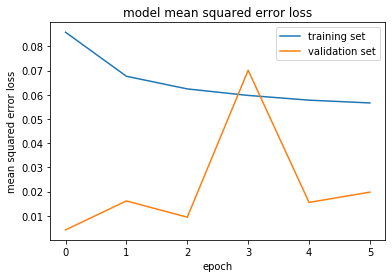

In [22]:
### print the keys contained in the history object
print(history_object_1.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object_1.history['loss'])
plt.plot(history_object_1.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

### Model 2: Nvidia Architecture
In the second model, I used Nvidia model architecture. However, to introduce nonlinearity I also included ELU activation function in all layers.ELU is very similar to RELU except negative inputs. They are both in identity function form for non-negative inputs. On the other hand, ELU becomes smooth slowly until its output equal to -α whereas RELU sharply smoothes.
In addition, to avoid overfitting all layers (except the last one) have dropout. 

In [17]:
# Set our batch size
batch_size = 32

# Compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

#Regression network: directly predict steering measurements
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout, Lambda
from keras.layers import Conv2D, MaxPooling2D, Cropping2D
import math
import matplotlib.pyplot as plt
import tensorflow as tf

with tf.device('/GPU:0'):
    model = Sequential()

    # Preprocess incoming data, centered around zero with small standard deviation 
    model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,3), output_shape=(160,320,3)))

    # Trimming image to only see relevant section with road
    model.add(Cropping2D(cropping=((70,25), (0,0))))

       
    #layer 1- Convolution, no of filters- 24, filter size= 5x5, stride= 2x2
    model.add(Conv2D(24,(5,5), activation = 'elu', strides=(2,2)))
    model.add(Dropout(0.4))

    #layer 2- Convolution, no of filters- 36, filter size= 5x5, stride= 2x2
    model.add(Conv2D(36,(5,5), activation = 'elu', strides=(2,2)))
    model.add(Dropout(0.4))

    #layer 3- Convolution, no of filters- 48, filter size= 5x5, stride= 2x2
    model.add(Conv2D(48,(5,5), activation = 'elu', strides=(2,2)))
    model.add(Dropout(0.4))

    #layer 4- Convolution, no of filters- 64, filter size= 3x3, stride= 1x1
    model.add(Conv2D(64,(3,3), activation = 'elu'))
    model.add(Dropout(0.4))

    #layer 5- Convolution, no of filters- 64, filter size= 3x3, stride= 1x1
    model.add(Conv2D(64,(3,3), activation = 'elu'))
    model.add(Dropout(0.4))

    #flatten image from 2D to side by side
    model.add(Flatten())

    #layer 6- fully connected layer 1
    model.add(Dense(100, activation = 'elu'))
    model.add(Dropout(0.3))

    #layer 7- fully connected layer 1
    model.add(Dense(50, activation = 'elu'))
    model.add(Dropout(0.3))

    #layer 8- fully connected layer 1
    model.add(Dense(10))

    #layer 9- fully connected layer 1
    model.add(Dense(1)) #here the final layer will contain one value as this is a regression problem and not classification


    model.compile(loss='mse',optimizer='adam')

    
    # Training the model and storing the training and validation loss metrics
    history_object_2 = model.fit_generator(train_generator, 
                        steps_per_epoch=math.ceil(len(train_samples)/batch_size), 
                        validation_data=validation_generator, 
                        validation_steps=math.ceil(len(validation_samples)/batch_size), 
                        epochs=15, verbose=1)
    
    
    #Saving the trained model
    model.save('model_2.h5')

Epoch 1/15
244/244 [==============================] - 135s 552ms/step - loss: 0.1009 - val_loss: 0.0728
Epoch 2/15
244/244 [==============================] - 134s 548ms/step - loss: 0.0809 - val_loss: 0.0657
Epoch 3/15
244/244 [==============================] - 135s 551ms/step - loss: 0.0772 - val_loss: 0.0563
Epoch 4/15
244/244 [==============================] - 133s 547ms/step - loss: 0.0748 - val_loss: 0.0387
Epoch 5/15
244/244 [==============================] - 133s 547ms/step - loss: 0.0738 - val_loss: 0.0738
Epoch 6/15
244/244 [==============================] - 133s 547ms/step - loss: 0.0721 - val_loss: 0.0930
Epoch 7/15
244/244 [==============================] - 134s 547ms/step - loss: 0.0708 - val_loss: 0.0799
Epoch 8/15
244/244 [==============================] - 134s 548ms/step - loss: 0.0705 - val_loss: 0.0974
Epoch 9/15
244/244 [==============================] - 133s 546ms/step - loss: 0.0714 - val_loss: 0.0649
Epoch 10/15
244/244 [==============================] - 135s 552m

### Model 2: Visualizing Loss

dict_keys(['val_loss', 'loss'])


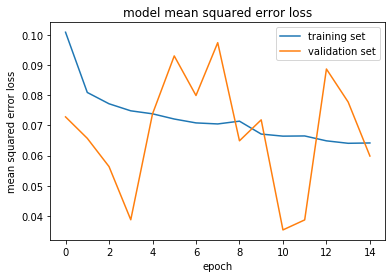

In [21]:
### print the keys contained in the history object
print(history_object_2.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object_2.history['loss'])
plt.plot(history_object_2.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()